La idea es tener un arbol con raiz, dirigido tal que la direccion de cada arista vaya de la raiz a las hojas. Dado un grafo de este estilo, se quieren etiquetar los nodos de manera aleatoria. Para etiquetar los nodos, estos se modelan como una cadena de markov, donde la etiqueta de un nodo depende unicamente de la etiqueta de su predecesor.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

Funciones para dibujar el arbol

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

In [3]:
def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
          
    if len(children) != 0:
        dx = width / 2 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    return pos

In [4]:
def draw_tree(tree, root=0, colores = "skyblue"):
    pos = hierarchy_pos(tree, root) 
    nx.draw(tree, pos, with_labels=True, node_size=700, node_color=colores, font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=1, alpha=0.7)
    plt.show()

## Generacion del arbol

Hay varias funciones para generar arboles aleatorios:

random_labeled_tree: 
https://networkx.org/documentation/stable/reference/generated/networkx.generators.trees.random_labeled_tree.html

random_unlabeled_tree:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.trees.random_unlabeled_tree.html

random_labeled_rooted_tree:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.trees.random_labeled_rooted_tree.html#networkx.generators.trees.random_labeled_rooted_tree

random_unlabeled_rooted_tree
https://networkx.org/documentation/stable/reference/generated/networkx.generators.trees.random_unlabeled_rooted_tree.html#networkx.generators.trees.random_unlabeled_rooted_tree


random_powerlaw_tree:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.random_powerlaw_tree.html#networkx.generators.random_graphs.random_powerlaw_tree

barabasi_albert_graph (poner m=1 para arbol):
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html#networkx.generators.random_graphs.barabasi_albert_graph


extended_barabasi_albert_graph:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.extended_barabasi_albert_graph.html#networkx.generators.random_graphs.extended_barabasi_albert_graph


In [5]:
from networkx import barabasi_albert_graph

De momento uso barabasi. Asumo que el nodo raiz del arbol generado es aquel con etiqueta 0

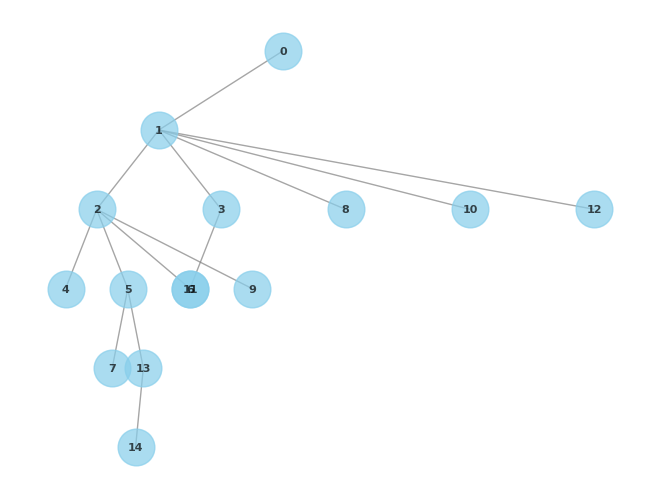

In [6]:
n = 15           # numero de nodos
nodo_raiz = 0    # podira cambiar

# hacer el arbol
arbol_barabasi = barabasi_albert_graph(n, 1)

# dibujar
draw_tree(arbol_barabasi, nodo_raiz)

El arbol es no dirigido, hacer que sea dirigido.

Donde las aristas se alejan de la raiz.

In [7]:
def convertir_a_arbol_dirigido(grafo_no_dirigido, nodo_raiz):
    
    # Encuentra la distancia de cada nodo al nodo raíz
    distancias = nx.single_source_shortest_path_length(grafo_no_dirigido, nodo_raiz)

    # Inicializa un grafo dirigido
    grafo_dirigido = nx.DiGraph()

    # Añade nodos al grafo dirigido
    grafo_dirigido.add_nodes_from(grafo_no_dirigido.nodes())

    # Añade aristas al grafo dirigido con dirección de nodo más cercano al nodo raíz a más lejano
    for nodo_destino, distancia in distancias.items():
        if nodo_destino != nodo_raiz:
            # Encuentra el nodo anterior en el camino hacia el nodo raíz
            nodo_anterior = min(grafo_no_dirigido.neighbors(nodo_destino), key=lambda x: distancias[x])

            # Añade una arista dirigida desde el nodo anterior al nodo destino
            grafo_dirigido.add_edge(nodo_anterior, nodo_destino)

    return grafo_dirigido

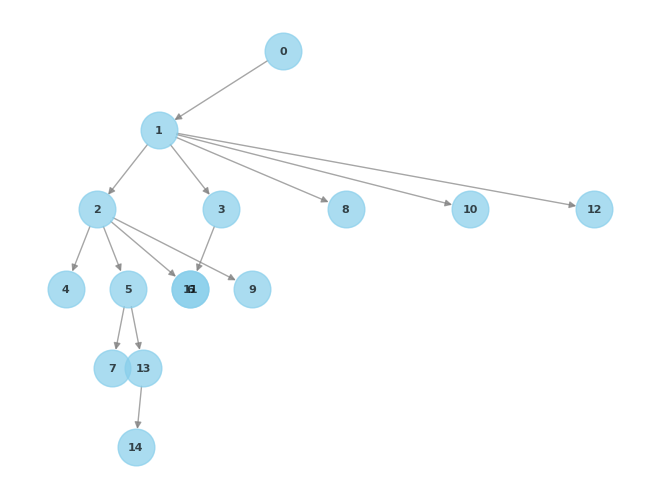

In [8]:
arbol = convertir_a_arbol_dirigido(arbol_barabasi, nodo_raiz)

# dibujar
draw_tree(arbol, nodo_raiz)

## Definir la cadena de markov de las etiquetas

Se define una cadena de markov, donde los estados son colores.

In [9]:
# estados de la cadena de markov
etiquetas = ['red', 'blue', 'green']

In [10]:
def generate_random_transition_matrix(states):
    
    num_states = len(states)

    # Generate a random matrix with values between 0 and 1
    random_matrix = np.random.rand(num_states, num_states)

    # Normalize the matrix so that each row sums to 1
    transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)

    return transition_matrix

In [11]:
# generar aleatoriamente la matriz de transicion de la cadena de markov
transition_matrix = generate_random_transition_matrix(etiquetas)

In [12]:
def visualize_markov_chain(states, transition_matrix):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph without labels
    for state in states:
        G.add_node(state, color=state)

    # Add edges with weights proportional to conditional probabilities
    for i in range(len(states)):
        for j in range(len(states)):
            weight = transition_matrix[i, j]
            if weight > 0:
                G.add_edge(states[i], states[j], weight=weight)
                
    # Extract node colors from the graph
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=1000, node_color=node_colors, font_size=10, font_color='white',
            font_weight='bold', edge_color='black', width=[edge[2]['weight'] * 10 for edge in G.edges(data=True)],
            arrowsize=20, connectionstyle='arc3,rad=0.1')  # Modified to draw edges between all pairs

    # Display the plot
    plt.show()

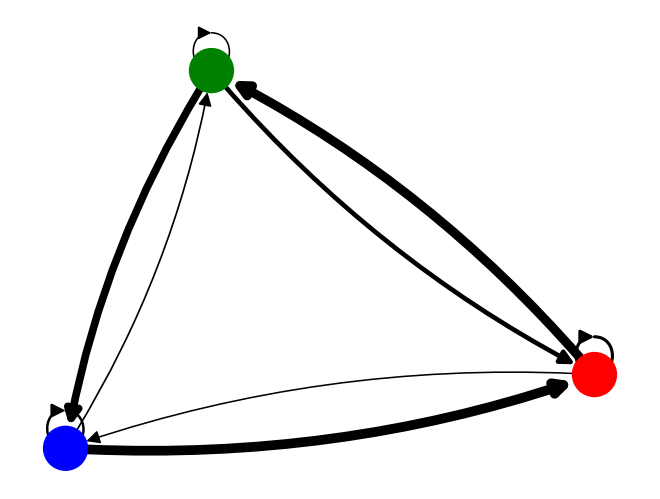

In [13]:
# ver la matriz de transicion
visualize_markov_chain(etiquetas, transition_matrix)

In [14]:
transition_matrix

array([[0.22407979, 0.11244462, 0.6634756 ],
       [0.69867718, 0.17925472, 0.1220681 ],
       [0.33635   , 0.55016468, 0.11348532]])

In [15]:
'''
transition_matrix[0, 0] = 0
transition_matrix[0, 0]=
transition_matrix[0, 0]=

transition_matrix[0, 0]=
transition_matrix[0, 0]=
transition_matrix[0, 0]=

transition_matrix[0, 0]=
transition_matrix[0, 0]=
transition_matrix[0, 0]=

'''

'\ntransition_matrix[0, 0] = 0\ntransition_matrix[0, 0]=\ntransition_matrix[0, 0]=\n\ntransition_matrix[0, 0]=\ntransition_matrix[0, 0]=\ntransition_matrix[0, 0]=\n\ntransition_matrix[0, 0]=\ntransition_matrix[0, 0]=\ntransition_matrix[0, 0]=\n\n'

## Etiquetar el arbol

Para etiquetar los nodos se va usar la cadena de markov, el color de un nodo solo depende del nodo de su predecesor.

In [16]:
etiquetas

['red', 'blue', 'green']

In [17]:
# tomar los nods del arbol
nodos = list(arbol.nodes)

In [18]:
def etiquetar(nodo, indice_etiqueta, indices_etiquetas):
    
    # tomar el indice del nodo
    indice_nodo = nodos.index(nodo)
    
    # llenar la lista, la entrada de ese nodo
    indices_etiquetas[indice_nodo] = indice_etiqueta

In [19]:
def elegir_indice_con_probabilidades(probabilidades):
    
    indices = list(range(len(probabilidades)))
    
    indice_elegido = random.choices(indices, weights=probabilidades, k=1)[0]
    
    return indice_elegido

In [20]:
def etiquetar_arbol(indice_etiqueta_raiz):
    
    # poner una etiqueta por nodo
    # de momento todos inician en -1
    indices_etiquetas = [-1] * len(nodos)
    
    # la etiqueta de la raiz se define antes de empezar
    print(f"La raiz {nodo_raiz} se etiqueta con color: {etiquetas[indice_etiqueta_raiz]}")

    # iterar en los nodos del grafo para etiquetar
    # iterar usando bfs

    visitados = set()
    cola = [nodo_raiz]

    # iterar mientras haya elementos en la cola
    while cola:
        # sacar el primero de la cola (bfs)
        nodo_actual = cola.pop(0)

        # si no se ha visto
        if nodo_actual not in visitados:

            print(f"Nodo a etiquetar: {nodo_actual}")
            # se etiqueta el nodo

            # si es la raiz, ya se definio la etiquera
            if nodo_actual == nodo_raiz:
                etiquetar(nodo_actual, indice_etiqueta_raiz, indices_etiquetas)
                print(f"Etiqueta: {etiquetas[indice_etiqueta_raiz]}\n")

            # no es la raiz,
            # definir la etiqueta con base a la etiqeuta del padre
            else:

                # tomar los padres
                padres_ = arbol.predecessors(nodo_actual)
                padres = [p for p in padres_]

                # comprobar que sesa solo 1, y tomarlo
                assert len(padres) == 1

                padre = padres[0]

                # tomar el indice de la etiqueta del padre
                indice_padre = nodos.index(padre)
                indice_etiqueta_padre = indices_etiquetas[indice_padre]

                # comprobar que ya tenga etiqueta
                assert indice_etiqueta_padre != -1

                # tomas las probabilidades
                proba_etiquetas = transition_matrix[indice_etiqueta_padre]

                # hacer un sampleo, segun estas probabilidades
                # para seleccionar el indice de esta etiqueta
                indice_etiqueta_actual = elegir_indice_con_probabilidades(proba_etiquetas)

                # etiquetar
                etiquetar(nodo_actual, indice_etiqueta_actual, indices_etiquetas)
                print(f"Etiqueta: {etiquetas[indice_etiqueta_actual]}\n")


            # como sea, se marca como visitado
            visitados.add(nodo_actual)

            # se añadren los siguientes nodos
            vecinos = list(arbol.successors(nodo_actual))
            cola.extend(vecinos)
            
    # devolver las etiquetas
    return indices_etiquetas

In [21]:
indices_etiquetas = etiquetar_arbol(0)

La raiz 0 se etiqueta con color: red
Nodo a etiquetar: 0
Etiqueta: red

Nodo a etiquetar: 1
Etiqueta: green

Nodo a etiquetar: 2
Etiqueta: blue

Nodo a etiquetar: 3
Etiqueta: blue

Nodo a etiquetar: 8
Etiqueta: red

Nodo a etiquetar: 10
Etiqueta: red

Nodo a etiquetar: 12
Etiqueta: red

Nodo a etiquetar: 4
Etiqueta: green

Nodo a etiquetar: 5
Etiqueta: red

Nodo a etiquetar: 6
Etiqueta: blue

Nodo a etiquetar: 9
Etiqueta: red

Nodo a etiquetar: 11
Etiqueta: green

Nodo a etiquetar: 7
Etiqueta: green

Nodo a etiquetar: 13
Etiqueta: green

Nodo a etiquetar: 14
Etiqueta: blue



In [22]:
print(indices_etiquetas)

# convertirlas en colores
colores_nodos = [etiquetas[i] for i in indices_etiquetas]

print(colores_nodos)

[0, 2, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 2, 1]
['red', 'green', 'blue', 'blue', 'green', 'red', 'blue', 'green', 'red', 'red', 'red', 'green', 'red', 'green', 'blue']


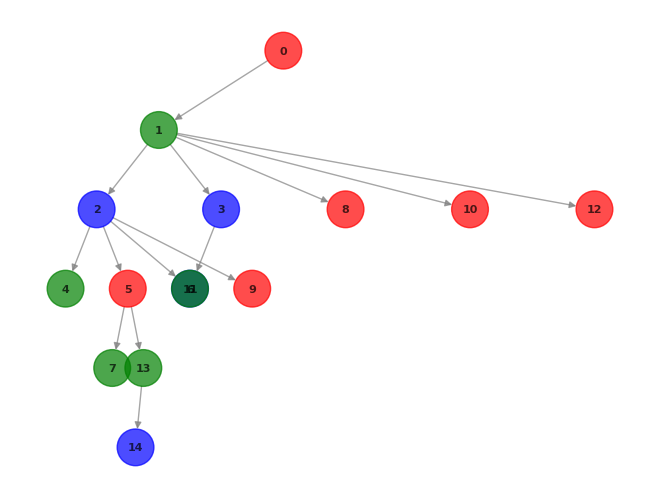

In [23]:
# dibujar
draw_tree(arbol, nodo_raiz, colores_nodos)